In [1]:
#Useful imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, asin, acos, atan
%reload_ext autoreload
%autoreload 2
plt.style.use('latex.mplstyle')

## Load and visualize data

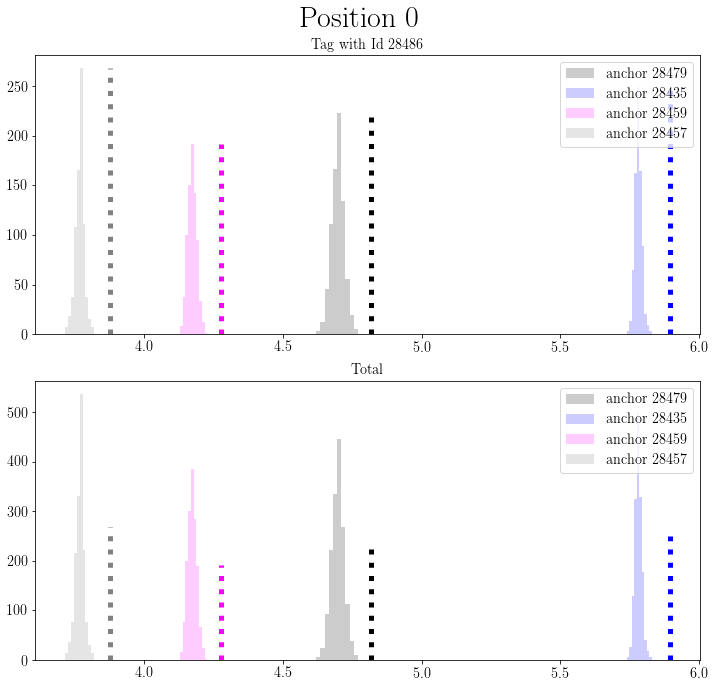

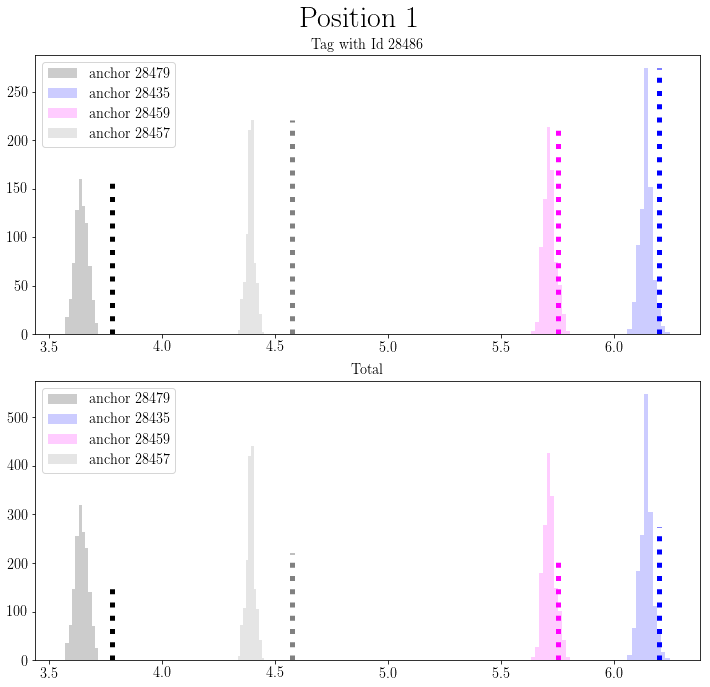

In [2]:
import plots_cti as plots
from experiments import read_experimental_data,N_POSITIONS

tool = 'Pozyx'
#tool = 'Ubiment'
#tool = 'Beacon'

april_tag_id = 333
pozyx_tag_id = 28486
beacon_tag_id = 444

if tool == 'Pozyx':
    path = 'data/Pozyx/Static/'
    name = 'pozyx_data_P{}.csv'
    runs = [0]
    tag_ids = [pozyx_tag_id]
    weighted = False
elif tool == 'Ubiment':
    path = 'data/Ubiment/Static/'
    name = 'data_P{}_{}.csv'
    runs = [1,2]
    tag_ids = [april_tag_id, pozyx_tag_id]
    weighted = True
elif tool == 'Beacon':
    path = 'data/Beacon/Static/'
    name = 'beacon_data_P{}.csv'
    runs = [1]
    tag_ids = [beacon_tag_id]
    weighted = False
    tool = 'Pozyx'


results, anchors = read_experimental_data(path, name, runs, tag_ids, weighted)

## Compare weights (Ubiment only)

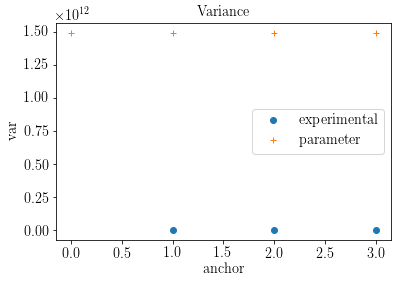

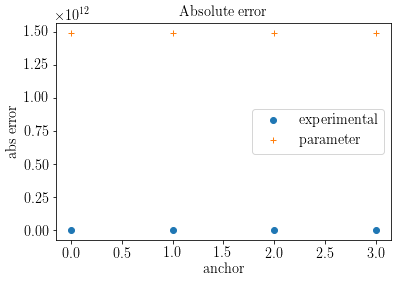

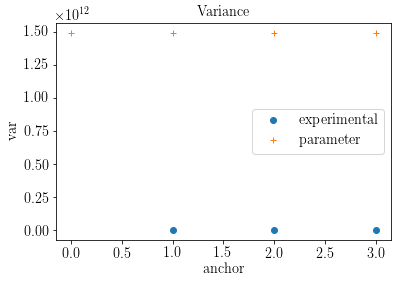

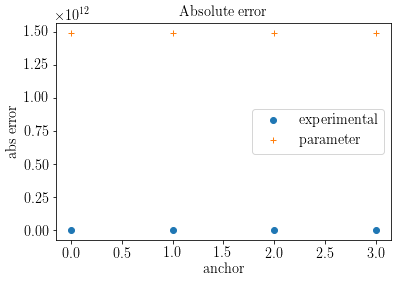

In [3]:
from point_configuration import HeterogenousConfiguration, PointConfiguration, dm_from_edm, create_from_points, edm_from_dm
from plots_cti import plot_matrix
index = -1
for result in results:
    var_exp = [np.var(d) for d in result.distances]
    var_exp[var_exp==0] = np.nan
    var = np.delete(result.var_avg[index,:],index)
    var[var==0] = np.nan
    plt.plot(var_exp, 'o', label='experimental')
    plt.plot(var, '+', label='parameter')
    plt.title('Variance')
    plt.xlabel('anchor')
    plt.ylabel('var')
    plt.legend(loc='best')
    plt.show()
    
    real_points = np.r_[anchors,result.real.reshape((1,-1))]
    porig = create_from_points(real_points, HeterogenousConfiguration)
    abs_error_exp = np.abs(np.sqrt(result.edm_avg[index,:]) - np.sqrt(porig.edm[index,:]))
    abs_error_exp[result.edm_avg[index,:]==0] = np.nan
    abs_error = np.delete(result.abs_error_avg[index,:],index)
    abs_error[abs_error==0] = np.nan
    
    plt.plot(abs_error_exp, 'o', label='experimental')
    plt.plot(abs_error, '+', label='parameter')
    plt.title('Absolute error')
    plt.xlabel('anchor')
    plt.ylabel('abs error')
    plt.legend(loc='best')
    plt.show()

In [4]:
def get_weights(weight_method):
    from basics import divide_where_nonzero
    if weight_method == 'LOESS':
        max_dik = np.max(pnoisy.edm,axis=1)**(0.5)
        max_dkj = np.max(pnoisy.edm,axis=0)**(0.5)
        weights_matrix = np.ones((N,N))
        for i in range(N):
            for j in range(N):
                hij = max(max_dik[i],max_dkj[j])
                weights_matrix[i,j] = np.exp(-pnoisy.edm[i,j]/hij**2)
    else:
        if weight_method == 'bias':
            if tool == 'Pozyx':
                # experimental bias 
                bias = np.sqrt(np.abs(porig.edm[index,other] - pnoisy.edm[index,other]))
            else:
                # parametric bias
                bias = result.abs_error_avg[index, other]
            
            weights = divide_where_nonzero(np.ones(bias.shape),bias)
        elif weight_method == 'sigma':
            if tool == 'Pozyx':
                # experimental sigma
                from basics import divide_where_nonzero
                sigma2 = np.array([np.var(d) for d in result.distances])
                sigma2[np.isnan(sigma2)] = 0
            
            else:
                # parametric sigma
                sigma2 = result.var_avg[index,other]
            weights = divide_where_nonzero(np.ones(sigma2.shape),sigma2)
        else:
            print('unknown weighting method')
        weights_matrix = np.ones((N,N))*max(weights)
        weights_matrix[index,other] = weights
        weights_matrix[other,index] = weights
    # set weights to zero where measurements are missing
    weights_matrix[pnoisy.edm == 0] = 0.0
    return weights_matrix

## Apply algorithms

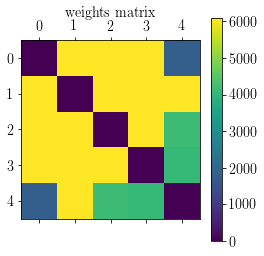

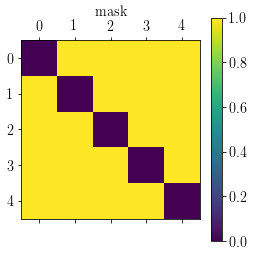

estimate using mds...
...done
estimate using weighted mds...
...done
estimate using SRLS...
...done
estimate using weighted SRlS...
...done


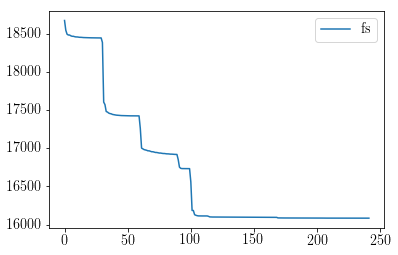

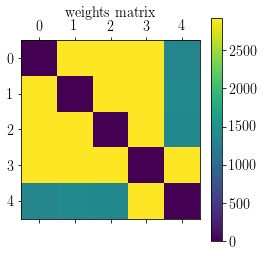

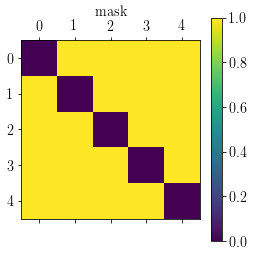

estimate using mds...
...done
estimate using weighted mds...
...done
estimate using SRLS...
...done
estimate using weighted SRlS...
...done


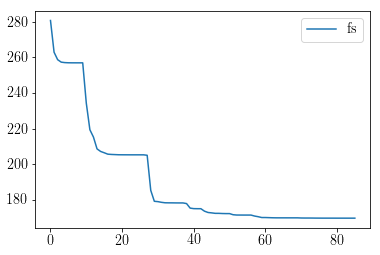

In [11]:
from point_configuration import HeterogenousConfiguration, PointConfiguration, dm_from_edm, create_from_points, edm_from_dm
from algorithms import reconstruct_mds, reconstruct_srls, reconstruct_acd
from plots_cti import plot_matrix
    
points_mds = []
points_mds_weighted = []
points_srls = []
points_srls_weighted = []
points_original = []

#weight_method = 'bias'
weight_method = 'sigma'
#weight_method = 'LOESS'

printout=False
for result in results:
    N = result.edm_avg.shape[0]
    real_points = np.r_[anchors,result.real.reshape((1,-1))]
    porig = create_from_points(real_points, HeterogenousConfiguration)
    index = N-1
    other = np.delete(np.arange(N),index)
    
    edm = result.edm_avg
    pnoisy = porig.copy()
    pnoisy.edm[index,other] = edm[index,other]
    pnoisy.edm[other,index] = edm[other,index]
    weights_matrix = get_weights(weight_method)
    plot_matrix(weights_matrix, 'weights matrix')
    mask = (weights_matrix != 0)
    plot_matrix(mask, 'mask')
    
    print('estimate using mds...')
    Xmds = reconstruct_mds(pnoisy.edm, porig.points, method='geometric', mask=mask)
    print('...done')
    print('estimate using weighted mds...')
    #X_0 = porig.points
    X_0 = Xmds
    Xmds_weighted, fs, err_edms, err_points = reconstruct_acd(pnoisy.edm, weights_matrix, X_0=X_0, real_points=porig.points, print_out=False)
    print('...done')
    print('estimate using SRLS...')
    Xsrls = reconstruct_srls(pnoisy.edm, porig.points, False, index=index, weights=mask)
    print('...done')
    print('estimate using weighted SRlS...')
    Xsrls_weighted = reconstruct_srls(pnoisy.edm, porig.points, False, weights=weights_matrix)
    print('...done')
    plt.plot(fs,label='fs')
    plt.legend(loc='best')
    plt.show()
    
    if (printout):
        plot_matrix(porig.edm, 'real EDM')
        plot_matrix(pnoisy.edm,'noisy EDM')
        plot_matrix(porig.edm-pnoisy.edm,'difference')
    
        pmds = create_from_points(Xmds, PointConfiguration)
        pmds_weighted = create_from_points(Xmds_weighted, PointConfiguration)
        psrls = create_from_points(Xsrls, PointConfiguration)
        psrls_weighted = create_from_points(Xsrls_weighted, PointConfiguration)
        print('Noisy edm error',np.linalg.norm(pnoisy.edm-porig.edm))
        print('SRLS edm error',np.linalg.norm(psrls.edm-porig.edm))
        print('MDS edm error ',np.linalg.norm(pmds.edm-porig.edm))
        plt.matshow(porig.edm-psrls.edm)
        plt.colorbar()
        plt.axis('off')
        plt.title('Diff SRLS {}'.format(i))
        plt.show()
        plt.matshow(porig.edm-pmds.edm)
        plt.colorbar()
        plt.axis('off')
        plt.title('Diff MDS {}'.format(i))
        plt.show()
    
    points_original.append(porig.points)
    points_mds.append(Xmds)
    points_mds_weighted.append(Xmds_weighted)
    points_srls.append(Xsrls)
    points_srls_weighted.append(Xsrls_weighted.copy())

## 2D Visualization

rmse mds 0.16839548054540268
rmse mds weighted 0.17617572968379344
rmse srls 0.2028143304642469
rmse srls weighted 0.19198432688666356


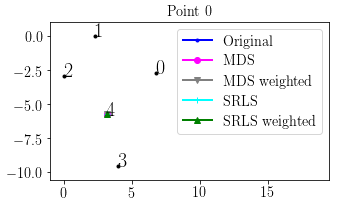

rmse mds 0.23168982003999936
rmse mds weighted 0.23271835668648358
rmse srls 0.2274568076683103
rmse srls weighted 0.23760028549563977


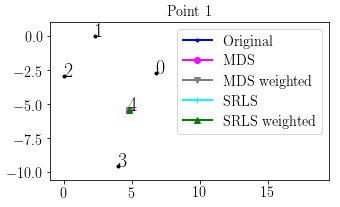

In [12]:
from plots_cti import plot_point_sets
from basics import rmse

n_methods = 4
names=['Original','MDS','MDS weighted','SRLS','SRLS weighted']
rmses = np.zeros((n_methods, N_POSITIONS))
size = [5,5]
for i in range(N_POSITIONS):
    Xorig = points_original[i]
    Xmds = points_mds[i]
    Xmds_weighted = points_mds_weighted[i]
    Xsrls = points_srls[i]
    Xsrls_weighted = points_srls_weighted[i]
    rmse_mds = rmse(Xmds[-1,:], Xorig[-1,:])
    rmse_srls = rmse(Xsrls[-1,:], Xorig[-1,:])
    rmse_srls_weighted = rmse(Xsrls_weighted[-1,:], Xorig[-1,:])
    rmse_mds_weighted = rmse(Xmds_weighted[-1,:], Xorig[-1,:])
    
    rmses[:,i] = [rmse_mds, rmse_mds_weighted, rmse_srls, rmse_srls_weighted]
    print('rmse mds', rmse_mds)
    print('rmse mds weighted', rmse_mds_weighted)
    print('rmse srls', rmse_srls)
    print('rmse srls weighted', rmse_srls_weighted)
    
    plot_point_sets([Xorig,Xmds,Xmds_weighted,Xsrls,Xsrls_weighted],'Point {}'.format(i),size=size,names=names)
    #plot_points(Xsrls, title='SRLS, rmse={:2.2e}'.format(rmse_slrs), size=size)
    #plot_points(Xmds, title='MDS, rmse={:2.2e}'.format(rmse_mds),size=size)

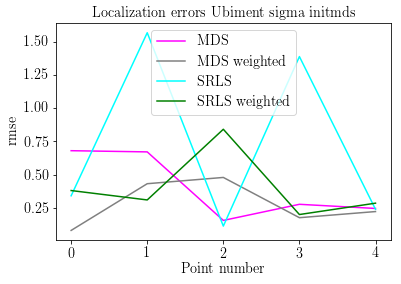

In [104]:
from plots_cti import COLORS
for i,method in enumerate(rmses):
    plt.plot(method,label=names[i+1],color=COLORS[i+2])
plt.legend(loc='best')
plt.xlabel('Point number')
plt.ylabel('rmse')
plt.title('Localization errors {} {} initmds'.format(tool,weight_method))
plt.savefig('results/rmse_{}_{}_initmds.png'.format(tool,weight_method))
plt.show()

## 3D Visualization

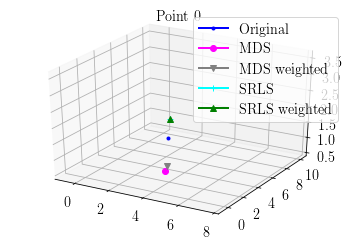

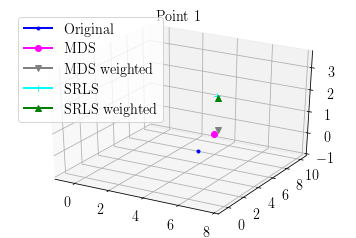

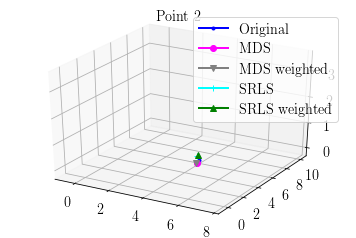

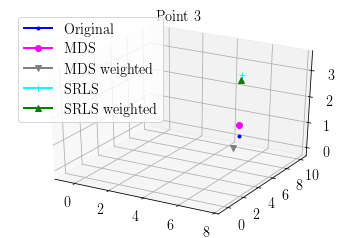

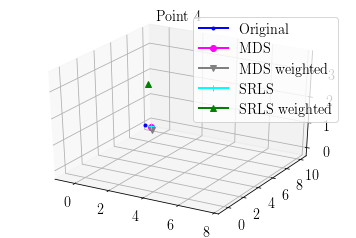

In [99]:
from plots_cti import plot_point_sets_3d

for i in range(N_POSITIONS):
    Xorig = points_original[i]
    Xmds = points_mds[i]
    Xsrls = points_srls[i]
    Xmds_weighted = points_mds_weighted[i]
    Xsrls_weighted = points_srls_weighted[i]
    plot_points = [Xorig, Xmds, Xmds_weighted, Xsrls, Xsrls_weighted]
    plot_point_sets_3d(plot_points, names, 'Point {}'.format(i))

In [90]:
real_points

array([[ 6.8 , -2.74,  1.96],
       [ 2.28,  0.  ,  2.01],
       [ 0.  , -2.98,  2.48],
       [ 3.97, -9.6 ,  2.06],
       [ 0.68, -3.46,  1.07]])